[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


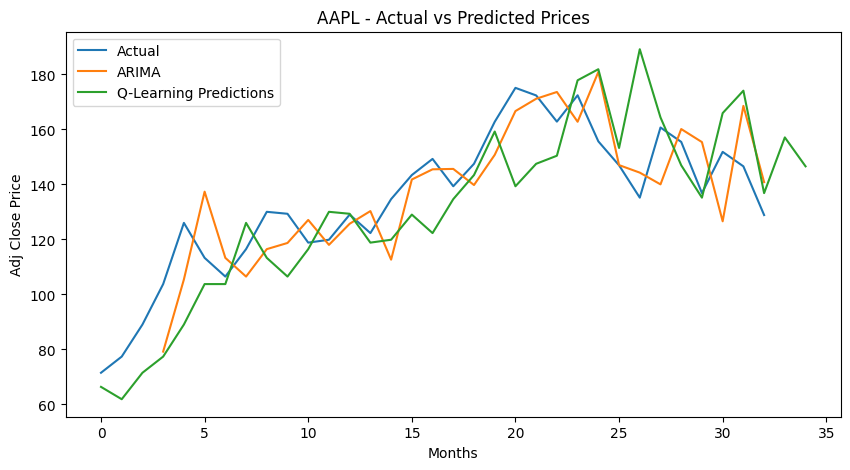

[*********************100%%**********************]  1 of 1 completed


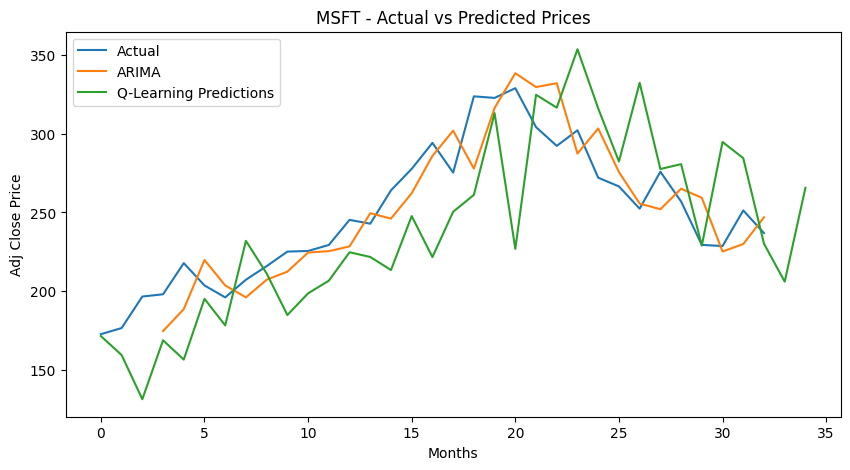

[*********************100%%**********************]  1 of 1 completed


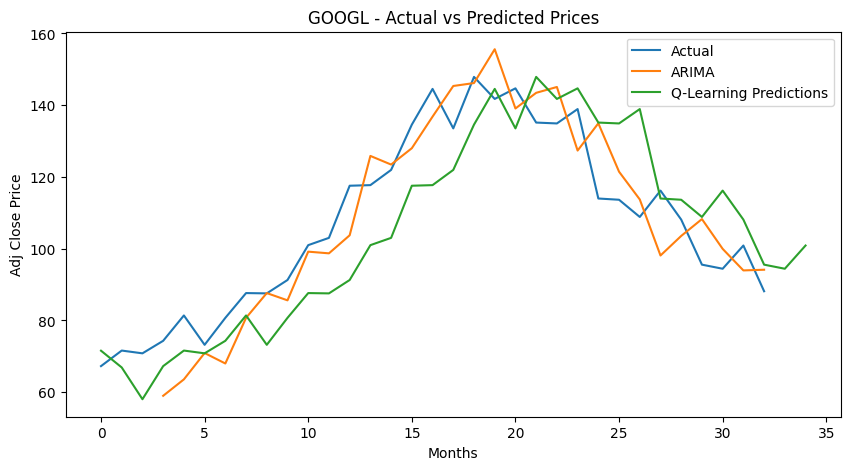

Shares for AAPL:
ARIMA Method:
2020-01-01 00:00:00: Method: ARIMA, Shares: 0
2020-02-01 00:00:00: Method: ARIMA, Shares: 0
2020-03-01 00:00:00: Method: ARIMA, Shares: 0
2020-04-01 00:00:00: Method: ARIMA, Shares: 0
2020-05-01 00:00:00: Method: ARIMA, Shares: 63.0
2020-06-01 00:00:00: Method: ARIMA, Shares: 111.0
2020-07-01 00:00:00: Method: ARIMA, Shares: 88.8
2020-08-01 00:00:00: Method: ARIMA, Shares: 71.03999999999999
2020-09-01 00:00:00: Method: ARIMA, Shares: 135.04
2020-10-01 00:00:00: Method: ARIMA, Shares: 198.04
2020-11-01 00:00:00: Method: ARIMA, Shares: 257.03999999999996
2020-12-01 00:00:00: Method: ARIMA, Shares: 205.63199999999998
2021-01-01 00:00:00: Method: ARIMA, Shares: 274.63199999999995
2021-02-01 00:00:00: Method: ARIMA, Shares: 340.63199999999995
2021-03-01 00:00:00: Method: ARIMA, Shares: 272.50559999999996
2021-04-01 00:00:00: Method: ARIMA, Shares: 344.50559999999996
2021-05-01 00:00:00: Method: ARIMA, Shares: 414.50559999999996
2021-06-01 00:00:00: Method: ARI

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

stock_symbols = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2022-12-31'
initial_capital = 100000

num_states = 3
num_actions = 3

alpha = 0.1
gamma = 0.9
epsilon = 0.1

def discretize(price, state_bounds):
    if price <= state_bounds[1]:
        return 0
    elif price <= state_bounds[2]:
        return 1
    else:
        return 2

def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(Q[state, :])

Q_tables = {}
predictions = {}
recommended_actions = {}

for stock_symbol in stock_symbols:
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval="1mo")
    Q = np.zeros((num_states, num_actions))
    predicted_prices = []
    actions = []
    min_price = min(stock_data['Adj Close'])
    max_price = max(stock_data['Adj Close'])
    price_range = max_price - min_price
    state_bounds = [min_price, min_price + 0.5 * price_range, max_price]

    for i in range(len(stock_data) - 1):
        state = discretize(stock_data['Adj Close'][i], state_bounds)
        action = choose_action(state)
        reward = stock_data['Adj Close'][i + 1] - stock_data['Adj Close'][i]
        next_state = discretize(stock_data['Adj Close'][i + 1], state_bounds)
        Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])

    Q_tables[stock_symbol] = Q

    for i in range(len(stock_data) - num_states):
        train_data = stock_data['Adj Close'][:i + num_states]
        if len(train_data) > 5:
            try:
                model = ARIMA(train_data, order=(5, 1, 0))
                model_fit = model.fit()
                forecast = model_fit.forecast()[0]
                predicted_prices.append(forecast)

                if i > 0:
                    prev_forecast = predicted_prices[-2]
                    if forecast > prev_forecast:
                        actions.append("Buy")
                    elif forecast < prev_forecast:
                        actions.append("Sell")
                    else:
                        actions.append("Hold")
            except (ValueError, np.linalg.LinAlgError) as e:
                predicted_prices.append(np.nan)
                actions.append("Hold")
        else:
            predicted_prices.append(np.nan)
            actions.append("Hold")

    predictions[stock_symbol] = predicted_prices
    recommended_actions[stock_symbol] = actions

for stock_symbol in stock_symbols:
    future_stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval="1mo")
    actual_prices = future_stock_data['Adj Close'].values[num_states:]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_prices, label='Actual')
    plt.plot(predictions[stock_symbol], label='ARIMA')

    q_learning_predictions = []
    for i in range(len(future_stock_data) - 1):
        state = discretize(future_stock_data['Adj Close'][i], state_bounds)
        action = np.argmax(Q_tables[stock_symbol][state, :])
        next_price = future_stock_data['Adj Close'][i] + (action - 1) * (future_stock_data['Adj Close'][i + 1] - future_stock_data['Adj Close'][i])
        q_learning_predictions.append(next_price)

    plt.plot(q_learning_predictions, label='Q-Learning Predictions')

    plt.title(stock_symbol + ' - Actual vs Predicted Prices')
    plt.xlabel('Months')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.show()

predicted_df = pd.DataFrame(predictions, index=stock_data.index[:-num_states])

portfolio_values = {symbol: [initial_capital / len(stock_symbols)] for symbol in stock_symbols}
shares = {symbol: [0] for symbol in stock_symbols}

for i in range(len(predicted_df)):
    for stock_symbol in stock_symbols:
        action = recommended_actions[stock_symbol][i]
        current_price = predicted_df[stock_symbol].iloc[i]
        if np.isnan(current_price):
            shares[stock_symbol].append(shares[stock_symbol][-1])
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1])
            continue

        if action == "Buy":
            investment = 0.2 * portfolio_values[stock_symbol][-1]
            new_shares = investment // current_price
            shares[stock_symbol].append(shares[stock_symbol][-1] + new_shares)
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1] - investment + new_shares * current_price)
        elif action == "Sell":
            sell_shares = 0.2 * shares[stock_symbol][-1]
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1] + sell_shares * current_price)
            shares[stock_symbol].append(shares[stock_symbol][-1] - sell_shares)
        else:
            shares[stock_symbol].append(shares[stock_symbol][-1])
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1])

for stock_symbol in stock_symbols:
    print(f"Shares for {stock_symbol}:")
    print("ARIMA Method:")
    for month, share_count in zip(predicted_df.index, shares[stock_symbol][1:]):
        print(f"{month}: Method: ARIMA, Shares: {share_count}")
    print("\nQ-Learning Method:")
    for month, share_count in zip(predicted_df.index, shares[stock_symbol][1:]):
        print(f"{month}: Method: Q-Learning, Shares: {share_count}")
